# 1. Setup

## 1.1 Install Dependencies

## 1.2 Import Dependencies

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [4]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
os.makedirs(NEG_PATH)
os.makedirs(POS_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [7]:
!tar -xf lfw.tgz


gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [8]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [9]:
anchor = tf.data.Dataset.list_files(f"{ANC_PATH}/*.jpg").take(250)
positive = tf.data.Dataset.list_files(f"{POS_PATH}/*.jpg").take(450)
negative = tf.data.Dataset.list_files(f"{NEG_PATH}/*.jpg").take(500)


In [10]:
dir_test = anchor.as_numpy_iterator()

In [11]:
print(dir_test.next())

b'data/anchor/3dfc46c6-4db2-11ef-ba7f-e452a3142c87.jpg'


## 3.2 Preprocessing - Scale and Resize

In [12]:
def preprocess(file_path):

    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)

    img = tf.image.resize(img, (100,100))
    img = img / 255.0

    return img

In [13]:
img = preprocess('/content/data/anchor/352994ac-4db2-11ef-a77d-e452a3142c87.jpg')

In [14]:
img.numpy().max()

0.82990193

## 3.3 Create Labelled Dataset

In [15]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [16]:
samples = data.as_numpy_iterator()

In [17]:
example = samples.next()

In [18]:
example

(b'data/anchor/44a6ef46-4db2-11ef-9f82-e452a3142c87.jpg',
 b'data/positive/aadbd3e3-4db2-11ef-a2e0-e452a3142c87.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [19]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [20]:
res = preprocess_twin(*example)

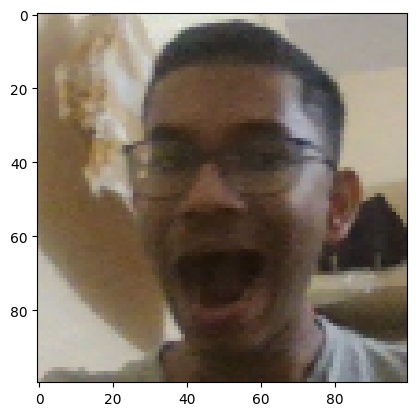

In [21]:
plt.imshow(res[1])

In [22]:
res[2]

1.0

In [23]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [24]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(8)
train_data = train_data.prefetch(8)

In [25]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(8)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [26]:
inp = Input(shape=(100,100,3), name='input_image')

In [27]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [28]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [29]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [30]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [31]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [32]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [33]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [34]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [35]:
embedding = make_embedding()

In [36]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [37]:
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [38]:
l1 = L1Dist()

## 4.3 Make Siamese Model

In [39]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [40]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [41]:
siamese_layer = L1Dist()

In [44]:
distances = siamese_layer(inp_embedding, val_embedding)

In [45]:
classifier = Dense(1, activation='sigmoid')(distances)

In [46]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_3')>

In [47]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [48]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [49]:
def make_siamese_model():

    input_image = Input(name='input_img', shape=(100,100,3))

    validation_image = Input(name='validation_img', shape=(100,100,3))

    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [50]:
siamese_model = make_siamese_model()

In [51]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 5. Training

## 5.1 Setup Loss and Optimizer

In [52]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [53]:
opt = tf.keras.optimizers.Adam(1e-4)

## 5.2 Establish Checkpoints

In [54]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [55]:
test_batch = train_data.as_numpy_iterator()

In [58]:
batch_1 = test_batch.next()

In [60]:
X = batch_1[:2]

In [59]:
y = batch_1[2]

In [61]:
y

array([1., 0., 0., 1., 1., 1., 0., 0.], dtype=float32)

In [62]:
@tf.function
def train_step(batch):

    with tf.GradientTape() as tape:

        X = batch[:2]

        y = batch[2]

        yhat = siamese_model(X, training=True)

        loss = binary_cross_loss(y, yhat)
    print(loss)

    grad = tape.gradient(loss, siamese_model.trainable_variables)

    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

## 5.4 Build Training Loop

In [63]:
from tensorflow.keras.metrics import Precision, Recall

In [64]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        r = Recall()
        p = Precision()

        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [65]:
EPOCHS = 10

In [66]:
train(train_data, EPOCHS)


 Epoch 1/10
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
44/44 [==============================] - 19s 205ms/step
0.101605155 0.8103448 1.0

 Epoch 2/10
44/44 [==============================] - 7s 167ms/step
0.33116218 0.94285715 1.0

 Epoch 3/10
44/44 [==============================] - 7s 164ms/step
0.006464532 0.98245615 1.0

 Epoch 4/10
44/44 [==============================] - 8s 170ms/step
0.012203737 0.982659 1.0

 Epoch 5/10
44/44 [==============================] - 8s 182ms/step
0.18857546 0.99404764 1.0

 Epoch 6/10
44/44 [==============================] - 7s 167ms/step
0.029445896 0.9814815 0.99375

 Epoch 7/10
44/44 [==============================] - 7s 167ms/step
0.011243582 0.9883041 1.0

 Epoch 8/10
44/44 [==============================] - 7s 166ms/step
0.020562297 1.0 1.0

 Epoch 9/10
44/44 [==============================] - 7s 164ms/step
0.02121625 0.94857144 0.988

# 6. Evaluate Model

## 6.1 Import Metrics

In [67]:
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [68]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [69]:
test_input.shape

(8, 100, 100, 3)

In [70]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 19ms/step


In [71]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 1, 0, 0, 1, 0]

In [72]:
y_true

array([0., 1., 0., 1., 0., 0., 1., 0.], dtype=float32)

## 6.3 Calculate Metrics

In [73]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [74]:
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [75]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 466ms/step
1.0 1.0


## 6.4 Viz Results

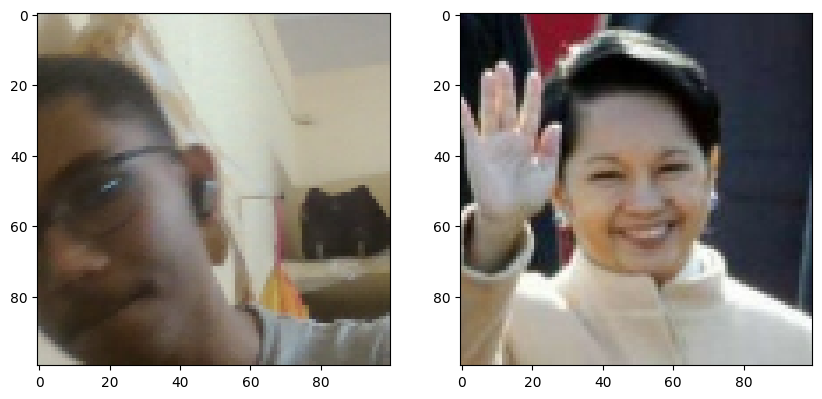

In [76]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[0])

plt.subplot(1,2,2)
plt.imshow(test_val[0])

plt.show()

# 7. Save Model

In [92]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [93]:
prediction = siamese_model.predict([test_input, test_val])
prediction = [1 if prediction > 0.5 else 0 for prediction in y_hat ]

1/1 [==============================] - 0s 31ms/step


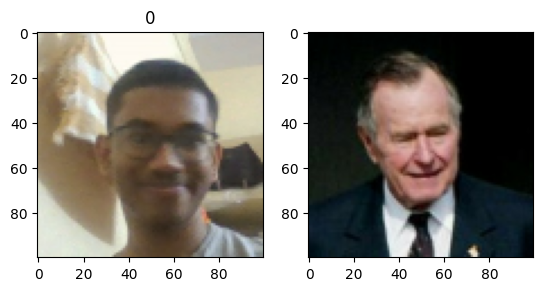

In [96]:
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.title(prediction[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])


In [97]:
test_input.shape

(8, 100, 100, 3)

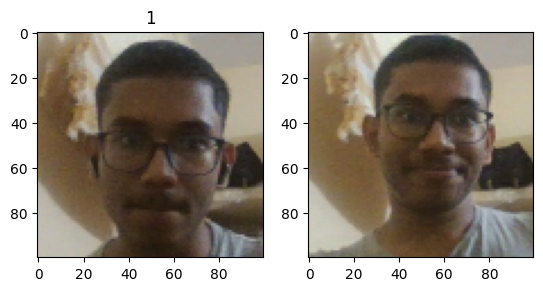

In [98]:
plt.subplot(1,2,1)
plt.imshow(test_input[1])
plt.title(prediction[1])
plt.subplot(1,2,2)
plt.imshow(test_val[1])
